<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Identifying Offensive Tweets

# Information

This is my capstone project for the General Assembly Data Science Immersive course.

This is the fourth notebook of this project.

In this notebook, the steps conducted are:

    1. Modelling - Support Vector Machine (SVM)
    
Model is done with hyperparameter tuning.

**CONTENT WARNING: This project includes content that are sensitive and may be offensive to some viewers. These topics include mentions (many negative) and slurs of race, religion, and gender.**

**NOTE: All text information that are used in this project are directly taken from the websites and do not reflect what I believe in. All tags (whether a tweet is racist/sexist, or not) are taken as is from the source.**

For the purpose of this project, the offensive tweets of interest are ones that are racist and sexist. 

Racist tweets are defined as those that have antagonistic sentiments toward certain religious figures or individuals from a religious group, and/or individuals or groups from a certain race. Given the dataset 'classified_tweets' not separating the racist and sacrilegious/blasphemous (anti-religious) tweets, the 'racist' tag will be applied for both categories.

Sexist tweets are defined as those that have misogynistic, homophobic, and/or transphobic sentiments.

# Background

Twitter is a micro-blogging social media platform with 217.5 million daily active users globally. With 500 million new tweets (posts) daily, the topics of these tweets varies widely – k-pop, politics, financial news… you name it! Individuals use it for news, entertainment, and discussions, while corporations use them to as a marketing tool to reach out to a wide audience. Given the freedom Twitter accords to its user, Twitter can provide a conducive environment for productive discourse, but this freedom can also be abused, manifesting in the forms of racism and sexism.

# Problem Statement

With Twitter’s significant income stream coming from advertisers, it is imperative that Twitter keeps a substantial user base. On the other hand, Twitter should maintain a safe space for users and provide some level of checks for the tweets the users put out into the public space, and the first step would be to identify tweets that espouse racist or sexist ideologies, and then Twitter can direct the users to appropriate sources of information where users can learn more about the community that they offend or their subconscious biases so they will be more aware of their racist/sexist tendencies. Thus, to balance, Twitter has to be accurate in filtering inappropriate tweets from innocuous ones, and the kind of inappropriateness of flagged tweets (tag - racist or sexist).

F1-scores will be the primary metric as it looks at both precision and recall, each looking at false positives (FPs) and false negatives (FNs) respectively, and is a popular metric for imbalanced data as is the case with the dataset used.

For the purpose of explanation, racist tweets are used as the ‘positive’ case.

In this context, FPs are the cases where the model erroneously flags out tweets as racist when the tweet is actually innocuous/sexist. FNs are cases where the model erroneously flags out tweets as innocuous/sexist but the tweets are actually racist.

There is a need to balance the identification of an offensive tweet when it is indeed offensive and the need to maintain a high level of user experience (something that would be jeopardized when the model erroneously flags innocuous tweets as offensive).

Thus, higher F1-score is the preferred metric to assess model performance.

# Importing Libraries

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP data cleaning and preprocessing
import re, string, nltk, itertools
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pickle to save model
import pickle

# For NLP Machine Learning processes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Pipeline
from imblearn.pipeline import Pipeline

# Support Vector Machine
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Changing display settings
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_row', 100)

# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Capstone/data/data_v1.csv')

In [ ]:
data.head()

,tag,set,text
0,2,train,way insult direct man unflattering hat worn predominantly men meant ins…
1,1,train,ordinary muslim idiot person like know make sure qur’an muslim nothing claim jihad come back tal...
2,1,train,give buildup sweeden government idiotu behave like allrounder see reach god know many fake news ...
3,0,train,sure pot cooked hot mkr killerblondes abarmezh86
4,1,train,christian part palestinian kill driven palestinian muslim


In [ ]:
# Split entire dataset into the two datasets
# train dataset: cyberbullying_tweets.csv and test dataset: classified_tweets.csv
train = data.loc[data['set'] == 'train']
test = data.loc[data['set'] == 'test']

In [ ]:
# Splitting both datasets into their respective X and y columns 
X1 = train['text']
y1 = train['tag']

X2 = test['text']
y2 = test['tag']

# Train/Test Split

This step splits the train dataset: cyberbullying_tweets.csv into the dataset that the classifier model will train on, and the validation dataset that the model will be assessed on.

In [ ]:
# Conducting train/validation split
X_train, X_val, y_train, y_val = train_test_split(X1, y1, stratify = y1, random_state = 42)

# Modelling - Support Vector Machine (SVM)

### Support Vector Machine (CountVectorizer)

In [ ]:
# Set up a pipeline:
# 1. Instantiating CountVectorizer
# 2. SMOTE sampling - due to imbalance of classes
# 3. Support Vector Machine
pipe_cvec_svm = Pipeline([
        ('cvec', CountVectorizer()),
        ('sampling', SMOTE(random_state = 42)),
        ('svc', SVC(random_state = 42))
    ])

In [ ]:
# Search over the following values of hyperparameters:

# SMOTE - number of k-nearest neighbours to conduct synthetic samples: 1 to 5
# Kernal coefficient: auto or scale
# Kernal type to be used: 'rbf', 'linear', 'poly', 'sigmoid'
# Regularization strength: 0.01, 0.1, 1, 10, 100
# To use or not to use the shrinking heuristics
# Setting weights for each class

# pipe_cvec_svc_params = {  
#     'sampling__k_neighbors': [1, 2, 3, 4, 5],      
#     'svc__gamma':['auto','scale'],                 
#     'svc__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
#     'svc__C' : [0.01, 0.1, 1, 10, 100],                             
#     'svc__shrinking' : [True, False],                    
#     'svc__class_weight' : ['balanced', None],           
    
# }

The above range of hyperparameters values are the ones that are searched.

In [ ]:
# For ease of running the notebook, will just use the best parameters retrieved from cvec_svm.best_params_
pipe_cvec_svc_params = {
    'sampling__sampling_strategy': ['minority'],   
    'sampling__k_neighbors': [4],      
    'svc__gamma':['auto'],                 
    'svc__kernel':['linear'],
    'svc__C' : [0.1],                             
    'svc__shrinking' : [True],                    
    'svc__class_weight' : ['balanced'],           
    
}

In [ ]:
# Instantiate GridSearchCV.
cvec_svm = GridSearchCV(pipe_cvec_svm,
                   param_grid = pipe_cvec_svc_params,
                   cv = 5,
                   scoring = 'f1_weighted',
                   n_jobs = -1,
                   verbose = 2) 

In [ ]:
%%time
# Conducting GridSearch on training data
cvec_svm.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 6.25 s, sys: 109 ms, total: 6.36 s
Wall time: 18.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('sampling', SMOTE(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [4],
                         'sampling__sampling_strategy': ['minority'],
                         'svc__C': [0.1], 'svc__class_weight': ['balanced'],
                         'svc__gamma': ['auto'], 'svc__kernel': ['linear'],
                         'svc__shrinking': [True]},
             scoring='f1_weighted', verbose=2)

In [ ]:
# Retrieving the best parameters resulting from the GridSearch
print(cvec_svm.best_params_)

{'sampling__k_neighbors': 4, 'sampling__sampling_strategy': 'minority', 'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto', 'svc__kernel': 'linear', 'svc__shrinking': True}


In [ ]:
# Best score
cvec_svm_best = round(cvec_svm.best_score_, 5)
print('CountVectorizer Support Vector Machine GridSearchCV best score is: {}.'.format(cvec_svm_best))

# Training score
c_svm_train_pred = cvec_svm.predict(X_train)
cvec_svm_train = round(f1_score(y_train, c_svm_train_pred, average = 'weighted'), 5)
print('CountVectorizer Support Vector Machine train score is: {}.'.format(cvec_svm_train))

# Validation score
c_svm_val_pred = cvec_svm.predict(X_val)
cvec_svm_val = round(f1_score(y_val, c_svm_val_pred, average = 'weighted'), 5)
print('CountVectorizer Support Vector Machine validation score is: {}.'.format(cvec_svm_val))

CountVectorizer Support Vector Machine GridSearchCV best score is: 0.92502.
CountVectorizer Support Vector Machine train score is: 0.9633.
CountVectorizer Support Vector Machine validation score is: 0.92713.


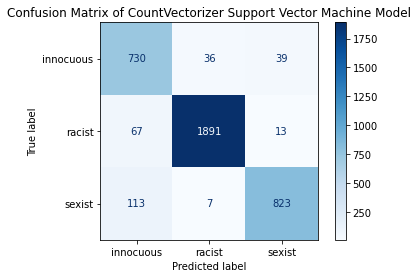

In [ ]:
# View confusion matrix
plot_confusion_matrix(cvec_svm, X_val, y_val, cmap = 'Blues', values_format = 'd',
                      display_labels = ['innocuous', 'racist', 'sexist'])
plt.title('Confusion Matrix of CountVectorizer Support Vector Machine Model');

### Support Vector Machine (TF-IDF)

In [ ]:
# Set up a pipeline:
# 1. Instantiating TF-IDF Vectorizer
# 2. SMOTE sampling - due to imbalance of classes
# 3. Support Vector Machine
pipe_tvec_svm = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('sampling', SMOTE(random_state = 42)),
        ('svc', SVC(random_state = 42))
    ])

In [ ]:
# Search over the following values of hyperparameters:

# SMOTE - number of k-nearest neighbours to conduct synthetic samples: 1 to 5
# Kernal coefficient: auto or scale
# Kernal type to be used: 'rbf', 'linear', 'poly', 'sigmoid'
# Regularization strength: 0.01, 0.1, 1, 10, 100
# To use or not to use the shrinking heuristics
# Setting weights for each class

# pipe_tvec_svc_params = { 
#     'sampling__k_neighbors': [1, 2, 3, 4, 5],      
#     'svc__gamma':['auto','scale'],                 
#     'svc__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
#     #'svc__probability' : [True],                   # [True]    # Cannot run when False
#     'svc__C' : [0.01, 0.1, 1, 10, 100],                             
#     'svc__shrinking' : [True, False],                    
#     'svc__class_weight' : ['balanced', None],           
    
# }

The above range of hyperparameters values are the ones that are searched.

In [ ]:
# For ease of running the notebook, will just use the best parameters retrieved from tvec_svm.best_params_
pipe_tvec_svc_params = {
    'sampling__sampling_strategy': ['minority'],   
    'sampling__k_neighbors': [5],      
    'svc__gamma':['scale'],                 
    'svc__kernel':['rbf'],
    'svc__C' : [100],                             
    'svc__shrinking' : [True],                    
    'svc__class_weight' : ['balanced'],           
    
}

In [ ]:
# Instantiate GridSearchCV
tvec_svm = GridSearchCV(pipe_tvec_svm,
                                param_grid = pipe_tvec_svc_params,
                                cv = 5,
                                scoring = 'f1_weighted',
                                n_jobs = -1,
                                verbose = 2) 

In [ ]:
%%time
# Conducting GridSearch on training data
tvec_svm.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 21.9 s, sys: 139 ms, total: 22.1 s
Wall time: 56 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('sampling', SMOTE(random_state=42)),
                                       ('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [5],
                         'sampling__sampling_strategy': ['minority'],
                         'svc__C': [100], 'svc__class_weight': ['balanced'],
                         'svc__gamma': ['scale'], 'svc__kernel': ['rbf'],
                         'svc__shrinking': [True]},
             scoring='f1_weighted', verbose=2)

In [ ]:
# Retrieving the best parameters resulting from the GridSearch
print(tvec_svm.best_params_)

{'sampling__k_neighbors': 5, 'sampling__sampling_strategy': 'minority', 'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__shrinking': True}


In [ ]:
# Best score
tvec_svm_best = round(tvec_svm.best_score_, 5)
print('TFIDF Support Vector Machine GridSearchCV best score is: {}.'.format(tvec_svm_best))

# Training score
t_svm_train_pred = tvec_svm.predict(X_train)
tvec_svm_train = round(f1_score(y_train, t_svm_train_pred, average = 'weighted'), 5)
print('TFIDF Support Vector Machine train score is: {}.'.format(tvec_svm_train))

# Validation score
t_svm_test_pred = tvec_svm.predict(X_val)
tvec_svm_val = round(f1_score(y_val, t_svm_test_pred, average = 'weighted'), 5)
print('TFIDF Support Vector Machine validation score is: {}.'.format(tvec_svm_val))

TFIDF Support Vector Machine GridSearchCV best score is: 0.92444.
TFIDF Support Vector Machine train score is: 0.9991.
TFIDF Support Vector Machine validation score is: 0.92461.


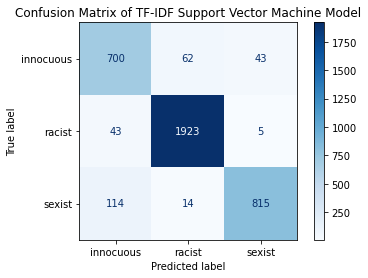

In [ ]:
# View confusion matrix
plot_confusion_matrix(tvec_svm, X_val, y_val, cmap = 'Blues', values_format = 'd',
                      display_labels = ['innocuous', 'racist', 'sexist'])
plt.title('Confusion Matrix of TF-IDF Support Vector Machine Model');

# Saving Models

This is done so that these models can be used to predict the labels on the test set.

In [ ]:
# Saving Support Vector Machine Models
# cvec
pickle.dump(cvec_svm, open('/content/drive/MyDrive/Capstone/data/cvec_svm.pkl', 'wb'))

# tvec
pickle.dump(tvec_svm, open('/content/drive/MyDrive/Capstone/data/tvec_svm.pkl', 'wb'))